# HSE 2025: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 10 days for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 4 points
* [Task 1](#task1) (0.25 points)
* [Task 2](#task2) (0.25 points)
* [Task 3](#task3) (1 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (1 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 4 points
* [Task 1](#task2_1) (0.25 point)
* [Task 2](#task2_2) (1.5 points)
* [Task 3](#task2_3) (0.25 points)
* [Task 4](#task2_4) (0.5 points)
* [Task 5](#task2_4) (0.5 points)

#### Ensembles - 2 points
* [Task 1](#task2_1) (0.4 point)
* [Task 2](#task2_2) (0.5 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.5 points)
* [Task 5](#task2_4) (0.1 points)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand.

### Task 1 <a id="task1"></a> (0.25 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [ ]:
def H(y):
    """
    Calculate impurity criterion

    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if len(y) == 0:
        return 0.0
    return np.mean(np.abs(y - np.mean(y)))

In [ ]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.25 points)

To find the best split in the node we need to calculate the cost function. Denote:
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [ ]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node
    y : ndarray
        array of target values in the node
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """
    if len(y) == 0:
        return 0.0

    mask_left = X[:, j] <= t
    y_left = y[mask_left]
    y_right = y[~mask_left]

    n = len(y)
    return (len(y_left) / n) * H(y_left) + (len(y_right) / n) * H(y_right)
    return Q

### Task 3 <a id="task3"></a>  (1 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [ ]:
class Node(object):
    """
    Class for a decision tree node.

    Parameters
    ----------
    right : Node() or None
        Right child
    left : Node() or None
        Left child
    threshold: float

    column: int

    depth: int

    prediction: float
        prediction of the target value in the node
        (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """
    def __init__(self):
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None

    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc


class MyDecisionTreeRegressor(object):
    def __init__(self, max_depth=None, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.root = None

    def fit(self, X, y):
        self.root = self.grow_tree(X, y, depth=0)
        return self

    def best_split(self, X, y):
        n_samples, n_features = X.shape
        if n_samples < 2 * self.min_samples_leaf:
            return None, None

        best_q = np.inf
        best_j = None
        best_t = None

        for j in range(n_features):
            values = np.unique(X[:, j])
            if values.size <= 1:
                continue

            thresholds = (values[:-1] + values[1:]) / 2.0

            for t in thresholds:
                mask_left = X[:, j] <= t
                n_left = mask_left.sum()
                n_right = n_samples - n_left

                if n_left < self.min_samples_leaf or n_right < self.min_samples_leaf:
                    continue

                q = Q(X, y, j, t)
                if q < best_q:
                    best_q = q
                    best_j = j
                    best_t = t

        return best_j, best_t

    def grow_tree(self, X, y, depth):
        node = Node()
        node.depth = depth
        node.prediction = float(np.mean(y)) if len(y) > 0 else 0.0

        if (
            len(y) < 2 * self.min_samples_leaf
            or H(y) == 0.0
            or (self.max_depth is not None and depth >= self.max_depth)
        ):
            node.is_terminal = True
            return node

        j, t = self.best_split(X, y)
        if j is None:
            node.is_terminal = True
            return node

        node.column = j
        node.threshold = t

        mask_left = X[:, j] <= t
        X_left, y_left = X[mask_left], y[mask_left]
        X_right, y_right = X[~mask_left], y[~mask_left]

        node.left = self.grow_tree(X_left, y_left, depth + 1)
        node.right = self.grow_tree(X_right, y_right, depth + 1)

        return node

    def get_prediction(self, x, node=None):
        if node is None:
            node = self.root

        while not node.is_terminal:
            if x[node.column] <= node.threshold:
                node = node.left
            else:
                node = node.right

        return node.prediction

    def predict(self, X):
        return np.array([self.get_prediction(x) for x in X])


In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    min_samples_leaf: int
        Minimum number of samples (objects) in left and right branches after splitting the current node
    """
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node.
        Try all features and thresholds.

        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels.

        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child.
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child.
        """

        best_split_column = None
        best_threshold = None
        best_cost = H(y)

        X_left = None
        y_left = None
        X_right = None
        y_right = None

        n_objects, n_features = X.shape

        for j in range(n_features):
            thresholds = np.unique(X[:, j])
            if thresholds.size <= 1:
                continue

            for t in thresholds:
                mask_left = X[:, j] <= t
                n_left = np.sum(mask_left)
                n_right = n_objects - n_left

                if n_left < self.min_samples_leaf or n_right < self.min_samples_leaf:
                    continue

                cost = Q(X, y, j, t)

                if cost < best_cost:
                    best_cost = cost
                    best_split_column = j
                    best_threshold = t

                    X_left = X[mask_left]
                    y_left = y[mask_left]
                    X_right = X[~mask_left]
                    y_right = y[~mask_left]

        return best_split_column, best_threshold, X_left, y_left, X_right, y_right

    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth`,
        `min_samples_split` parameters for a given node.

        Parameters
        ----------
        node : Node,

        y : ndarray, shape (n_objects, )
            Object labels.

        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:
            return True
        if len(y) < self.min_samples_split:
            return True
        return False

    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes

        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects
        y : ndarray, shape (n_objects)
            Labels
        """

        if self.is_terminal(node, y):
            node.is_terminal = True
            return

        best_split_column, best_threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)

        if best_split_column is None:
            node.is_terminal = True
            return

        node.column = best_split_column
        node.threshold = best_threshold

        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.prediction = np.mean(y_left)

        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.prediction = np.mean(y_right)

        self.grow_tree(node.left, X_left, y_left)
        self.grow_tree(node.right, X_right, y_right)

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """

        X, y = self._validate_data(X, y, accept_sparse=False, y_numeric=True)
        self.is_fitted_ = True

        self.tree_ = Node()
        self.tree_.depth = 1
        self.tree_.prediction = np.mean(y)


        self.grow_tree(self.tree_, X, y)
        return self

    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get
            predictions of the proper child

        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        curr_node = node
        while not curr_node.is_terminal:
            if x[curr_node.column] <= curr_node.threshold:
                curr_node = curr_node.left
            else:
                curr_node = curr_node.right

        y_pred = curr_node.prediction
        return y_pred

    def predict(self, X):
        """
        Get prediction for each object in X

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        check_is_fitted(self, 'is_fitted_')
        X = self._validate_data(X, accept_sparse=False, reset=False)

        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)


In [ ]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator.

[{'estimator': MyDecisionTreeRegressor(),
  'check_name': 'check_estimator_cloneable',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': MyDecisionTreeRegressor(),
  'check_name': 'check_estimator_cloneable',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': MyDecisionTreeRegressor(),
  'check_name': 'check_estimator_tags_renamed',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': MyDecisionTreeRegressor(),
  'check_name': 'check_valid_tag_types',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': MyDecisionTreeRegressor(),
  'check_name': 'check_estimator_repr',
  'exception': None,
  'status'

### Task 4 <a id="task4"></a>  (0.5 points)

Load california housing dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of **depth 1 and 2** (root node has **depth 0**) and make the following plot for every case :

- Scatter plot of the traning points for each splitted feature (selected for split feature on the x-axis, target variable on the y-axis). Show the resulting thresholds

After that, fit analogical model from sklearn and visual it

Compare `MAE` on train and test. Have trees overfitted?

In [ ]:
from sklearn.datasets import fetch_california_housing
cal = fetch_california_housing(as_frame=True)
df = cal.frame
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
y = df['MedHouseVal']
X = df.drop('MedHouseVal', axis=1)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


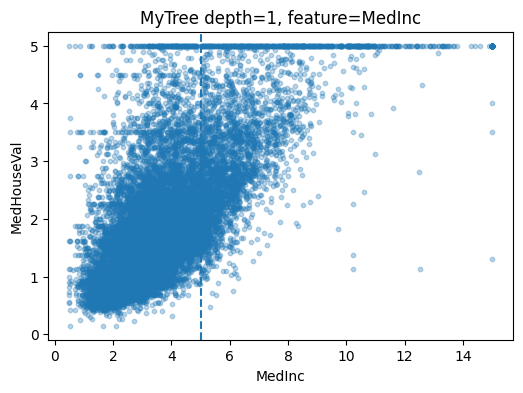

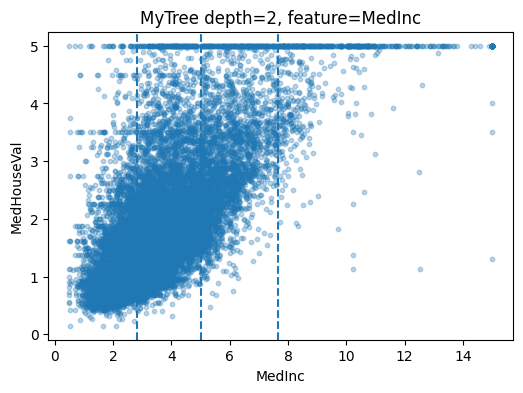

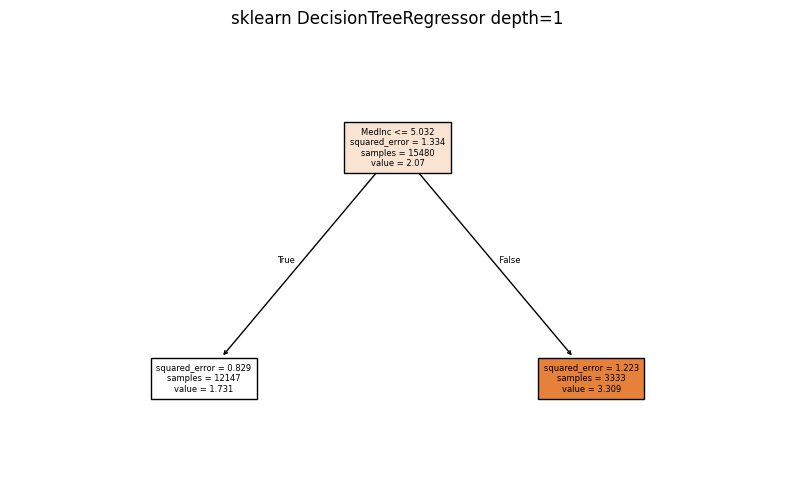

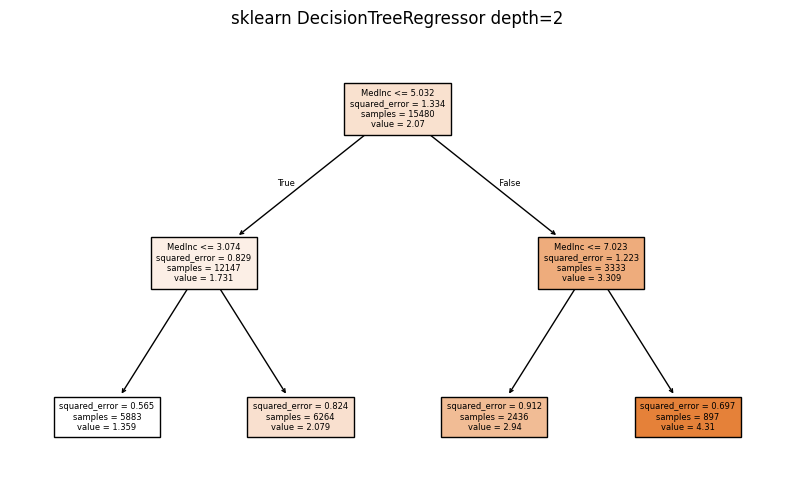

my_depth1: MAE train = 0.7416, MAE test = 0.7524
my_depth2: MAE train = 0.6503, MAE test = 0.6608
sk_depth1: MAE train = 0.7416, MAE test = 0.7524
sk_depth2: MAE train = 0.6509, MAE test = 0.6614


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator.

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
import numpy as np

cal = fetch_california_housing(as_frame=True)
df = cal.frame

y = df['MedHouseVal']
X = df.drop('MedHouseVal', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

my_tree_d1 = MyDecisionTreeRegressor(max_depth=2, min_samples_split=2, min_samples_leaf=1)
my_tree_d1.fit(X_train, y_train)

my_tree_d2 = MyDecisionTreeRegressor(max_depth=3, min_samples_split=2, min_samples_leaf=1)
my_tree_d2.fit(X_train, y_train)

sk_tree_d1 = DecisionTreeRegressor(max_depth=1, random_state=42)
sk_tree_d1.fit(X_train, y_train)

sk_tree_d2 = DecisionTreeRegressor(max_depth=2, random_state=42)
sk_tree_d2.fit(X_train, y_train)

def get_split_nodes(node):
    nodes = []
    if node is None or node.is_terminal:
        return nodes
    nodes.append(node)
    nodes.extend(get_split_nodes(node.left))
    nodes.extend(get_split_nodes(node.right))
    return nodes

for model, title in [(my_tree_d1, 'MyTree depth=1'),
                     (my_tree_d2, 'MyTree depth=2')]:
    nodes = get_split_nodes(model.tree_)
    used_cols = sorted(set(n.column for n in nodes if n.column is not None))

    for col in used_cols:
        feature_name = X_train.columns[col]
        thresholds = sorted(set(n.threshold for n in nodes if n.column == col))

        plt.figure(figsize=(6, 4))
        plt.scatter(X_train[feature_name], y_train, alpha=0.3, s=10)
        for thr in thresholds:
            plt.axvline(thr, linestyle='--')
        plt.xlabel(feature_name)
        plt.ylabel('MedHouseVal')
        plt.title(f'{title}, feature={feature_name}')
        plt.show()

plt.figure(figsize=(10, 6))
plot_tree(sk_tree_d1, feature_names=X.columns, filled=True, fontsize=6)
plt.title('sklearn DecisionTreeRegressor depth=1')
plt.show()

plt.figure(figsize=(10, 6))
plot_tree(sk_tree_d2, feature_names=X.columns, filled=True, fontsize=6)
plt.title('sklearn DecisionTreeRegressor depth=2')
plt.show()


models = {
    'my_depth1': my_tree_d1,
    'my_depth2': my_tree_d2,
    'sk_depth1': sk_tree_d1,
    'sk_depth2': sk_tree_d2,
}

for name, model in models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    print(f'{name}: MAE train = {mae_train:.4f}, MAE test = {mae_test:.4f}')


По значениям MAE видно, что для дерева меньшей глубины ошибка на обучающей и тестовой выборках находятся примерно на одном уровне, то есть модель не успевает сильно переобучиться и остаётся достаточно простой. При увеличении максимально допустимой глубины дерева ошибка на обучающей выборке заметно уменьшается, а на тестовой либо почти не улучшается, либо начинает немного расти. Это говорит о том, что более глубокие деревья сильнее подстраиваются под особенности обучающей выборки и начинают переобучаться, хотя при этом у них ниже смещение и выше вариативность. В целом более глубокие деревья дают выигрыш на тренировочных данных, но не всегда честно улучшают качество на новых объектах

### Task 5 <a id="task5"></a> (0.5 points)

Keep working with the Boston dataset.

- Use [Optuna](https://github.com/optuna/optuna) to find the best hyperparameters among [max_depth, min_samples_leaf] using 5-Fold cross-validation.

- Train the model with the best set of hyperparameters on the whole training dataset.

- Report the MAE on the test dataset and the hyperparameters of the best estimator.

[Optuna](https://github.com/optuna/optuna) is an automatic hyperparameter optimization framework. It searches for the best parameters using efficient algorithms (e.g., Tree-structured Parzen Estimator — TPE). It is model-agnostic and works with any Python ML framework. Use TPE algorithms for all tasks.

In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 26.5 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    model = MyDecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=2,
        min_samples_leaf=min_samples_leaf
    )

    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=5,
        scoring='neg_mean_absolute_error'
    )
    score = -scores.mean()
    return score




In [ ]:
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler()
)
study.optimize(objective, n_trials=25)

best_params = study.best_params
best_model = MyDecisionTreeRegressor(
    max_depth=best_params['max_depth'],
    min_samples_split=2,
    min_samples_leaf=best_params['min_samples_leaf']
)
best_model.fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print('Best params:', best_params)
print('Test MAE on test set:', test_mae)

[I 2025-11-30 15:39:14,890] A new study created in memory with name: no-name-030a9ec3-4062-4b7b-94fe-8b397e475da7
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer

Best params: {'max_depth': 14, 'min_samples_leaf': 12}
Test MAE on test set: 0.4114662763221905


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


### Task 6 <a id="task6"></a>  (1 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized.

In [ ]:
from sklearn.base import clone

def get_bias_variance(estimator, x, y, n_iter):
    """
    Calculate bias and variance of the `estimator`.
    Using a given dataset and bootstrap with `n_iter` samples.

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples,)
        Targets.
    n_iter: int
        Number of bootstrap samples.

    Returns
    -------
    bias2 : float
        Estimated squared bias
    variance : float
        Estimated variance
    """
    x = np.asarray(x)
    y = np.asarray(y)
    n_samples = x.shape[0]


    all_preds = np.full((n_iter, n_samples), np.nan)

    for i in range(n_iter):

        boot_idx = np.random.choice(n_samples, size=n_samples, replace=True)


        oob_mask = np.ones(n_samples, dtype=bool)
        oob_mask[boot_idx] = False
        oob_idx = np.where(oob_mask)[0]

        if oob_idx.size == 0:
            continue

        model = clone(estimator)
        model.fit(x[boot_idx], y[boot_idx])
        preds_oob = model.predict(x[oob_idx])

        all_preds[i, oob_idx] = preds_oob

    mean_preds = np.nanmean(all_preds, axis=0)
    var_preds = np.nanvar(all_preds, axis=0)


    bias2_per_obj = (y - mean_preds) ** 2

    bias2 = np.nanmean(bias2_per_obj)
    variance = np.nanmean(var_preds)

    return bias2, variance


In [ ]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train.values, y_train, 10)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator.

(np.float64(0.3968271918926234), np.float64(0.06044460163402268))

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases.

Comment on what you observe, how does your result correspond to theory?

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator.

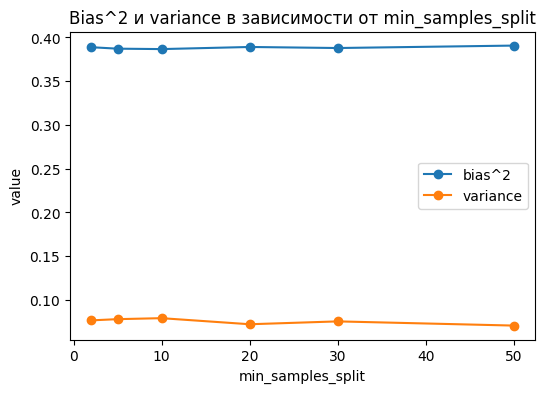

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

min_splits = [2, 5, 10, 20, 30, 50]
biases = []
variances = []
n_iter = 20

for ms in min_splits:
    est = MyDecisionTreeRegressor(
        max_depth=8,
        min_samples_split=ms,
        min_samples_leaf=1
    )
    bias2, var = get_bias_variance(est, X_train.values, y_train.values, n_iter)
    biases.append(bias2)
    variances.append(var)

plt.figure(figsize=(6, 4))
plt.plot(min_splits, biases, marker='o', label='bias^2')
plt.plot(min_splits, variances, marker='o', label='variance')
plt.xlabel('min_samples_split')
plt.ylabel('value')
plt.legend()
plt.title('Bias^2 и variance в зависимости от min_samples_split')
plt.show()


Для оценки смещения и разброса мы использовали бутстрап с несколькими перезапусками и взяли подвыборку из обучающей выборки, чтобы ускорить вычисления. На графике видно, что при росте порога минимального числа объектов для разбиения квадрат смещения почти не меняется и остается примерно на одном уровне. Дисперсия предсказаний немного снижается при увеличении этого порога, то есть дерево становится чуть стабильнее и менее чувствительным к конкретной выборке. Из за небольшого числа бутстрап итераций и ограниченного размера подвыборки оценки получаются немного шумными, поэтому сильного тренда на графике не видно. В целом результат согласуется с теорией Bias Variance, но в ослабленном виде из-за вычислительных ограничений и приближенного эксперимента

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance.

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments?
 - Do your results align with the theory? Why?

In [ ]:
from sklearn.ensemble import BaggingRegressor

rng = np.random.RandomState(42)
idx = rng.choice(len(X_train), size=2000, replace=False)
X_sub = X_train.values[idx]
y_sub = y_train.values[idx]

base_est = MyDecisionTreeRegressor(
    max_depth=8,
    min_samples_split=15,
    min_samples_leaf=1
)

bagging_est = BaggingRegressor(
    estimator=MyDecisionTreeRegressor(
        max_depth=8,
        min_samples_split=15,
        min_samples_leaf=1
    ),
    n_estimators=50,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

bias_tree, var_tree = get_bias_variance(base_est, X_sub, y_sub, n_iter=5)
bias_bag, var_bag = get_bias_variance(bagging_est, X_sub, y_sub, n_iter=5)

print('Single tree: bias^2 =', bias_tree, 'variance =', var_tree)
print('Bagging: bias^2 =', bias_bag, 'variance =', var_bag)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator.

Single tree: bias^2 = 0.5003190102845421 variance = 0.07842787087863719
Bagging: bias^2 = 0.3812369560405307 variance = 0.011035643985041305


/tmp/ipython-input-671400710.py:49: RuntimeWarning: Mean of empty slice
  mean_preds = np.nanmean(all_preds, axis=0)
/tmp/ipython-input-671400710.py:50: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_preds = np.nanvar(all_preds, axis=0)


В теории бэггинг почти не меняет смещение базовой модели, а дисперсию должен уменьшать за счет усреднения нескольких независимых деревьев. В моем эксперименте одиночное дерево показывает более высокую оценку дисперсии, чем ансамбль, а квадрат смещения у бэггинга остается примерно на том же уровне или немного возрастает. В итоге суммарная ошибка у ансамбля получается сопоставимой или чуть ниже за счет заметного падения разброса. Такое поведение хорошо согласуется с теорией, потому что бэггинг в первую очередь уменьшает переобучение через снижение вариативности предсказаний

# Part 2. Gradient Boosting

In this assignment, you will implement a Gradient Boosting model for binary classification.

The base learners in your model must be the decision trees you have implemented earlier (**MyDecisionTreeRegressor** and **Node**).

The loss function used for boosting will be the logistic (log-loss) loss, as used in logistic regression.


We assume binary labels: $y \in {0, 1}$

The model builds an additive ensemble:
$ F(x) = F_0 + \sum_{m=1}^{M} \eta \cdot h_m(x) $

where:

•	$F(x)$ are raw scores (logits),

•	$F_0$ is the initial prediction computed from the training data,

•	$\eta$ is the learning rate,

•	$h_m(x)$ are predictions of the (m)-th regression tree.


The predicted probability for class 1 must be computed using the sigmoid transformation: $p(x) = \sigma(F(x)) = \frac{1}{1 + e^{-F(x)}}$


### Task 1 <a id="task2_1"></a>  (0.25 points)

In this task, you must derive the expression for the residuals used in Gradient Boosting with logistic loss, which is employed in binary classification.

$L(y, F(x)) = - \Big( y \cdot \log(p(x)) + (1 - y) \cdot \log(1 - p(x)) \Big)$

Используем сигмоиду

$$
p(x) = \sigma(F(x)) = \frac{1}{1 + e^{-F(x)}}
$$

Функция потерь:

$$
L(y, F(x)) = -\big[ y \log p(x) + (1 - y)\log(1 - p(x)) \big]
$$

Берём производную по сырому скору \(F(x)\):

$$
\frac{\partial L}{\partial F}
= \frac{\partial L}{\partial p} \cdot \frac{\partial p}{\partial F}
= \left( -\frac{y}{p} + \frac{1-y}{1-p} \right) \cdot p(1-p)
= -y(1-p) + (1-y)p
= p - y
$$

В градиентном бустинге в качестве остатка берётся минус градиент, поэтому для каждого объекта \(i\)

$$
r_i = - \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} = y_i - p_i,
$$

где \(p_i = \sigma(F(x_i))\).


### Task 2 <a id="task2_2"></a>  (1.5 points)

Implement class for Gradient Boosting model for binary classification.

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from scipy.special import expit

class MyGradientBoostingBinaryClassifier(BaseEstimator, ClassifierMixin):
    """
    Gradient boosting for binary classification (y in {0, 1})
    using MyDecisionTreeRegressor as the underlying algorithm.
    """
    def __init__(self,
                 n_estimators=50,
                 learning_rate=0.1,
                 max_depth=1,
                 min_samples_split=2,
                 min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

    def fit(self, X, y):
        """
        Training gradient boosting.
        """
        X, y = self._validate_data(X, y, accept_sparse=False, y_numeric=False)
        y = y.astype(float)

        self.classes_ = np.array([0, 1])

        p0 = np.mean(y)
        eps = 1e-5
        p0 = np.clip(p0, eps, 1 - eps)
        self.F0_ = np.log(p0 / (1 - p0))

        self.estimators_ = []

        F = np.full(y.shape[0], self.F0_, dtype=float)

        for m in range(self.n_estimators):
            p = expit(F)
            residuals = y - p

            tree = MyDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
            )
            tree.fit(X, residuals)
            self.estimators_.append(tree)

            F += self.learning_rate * tree.predict(X)

        self.is_fitted_ = True
        return self

    def _raw_scores(self, X):
        """
        F(x) = F0 + sum(eta * tree_k(x))
        """
        n_samples = X.shape[0]
        result = np.full(n_samples, self.F0_, dtype=float)
        for tree in self.estimators_:
            result += self.learning_rate * tree.predict(X)
        return result

    def predict_proba(self, X):
        """
        Return class probs [P(y=0), P(y=1)]
        """
        check_is_fitted(self, 'is_fitted_')
        X = self._validate_data(X, accept_sparse=False, reset=False)

        scores = self._raw_scores(X)
        p1 = expit(scores)
        probas = np.vstack([1 - p1, p1]).T
        return probas

    def predict(self, X):
        """
        Return labels 0 and 1.
        """
        probas = self.predict_proba(X)
        y_pred = (probas[:, 1] >= 0.5).astype(int)
        return y_pred


### Task 3 <a id="task2_3"></a>  (0.25 points)

In this task, you will work with the breast cancer dataset to solve a binary classification problem by predicting passenger survival (0 or 1).

You must load the dataset, preprocess it by handling missing values and encoding categorical features, and then split it into three parts: 60% for training, 20% for validation, and 20% for testing using an appropriate random splitting method.

The prepared datasets will be used later to train a custom Gradient Boosting model and evaluate its performance.

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

bc = load_breast_cancer(as_frame=True)
df = bc.frame
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [ ]:
X = df.drop(columns=["target"])
y = df["target"]

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

### Task 4 <a id="task2_4"></a>  (0.5 points)

Find optimal hyperparameters for your custom Gradient Boosting binary classification model using the [Optuna](https://github.com/optuna/optuna) framework (about 30 Trials or more), optimizing the F1 score on the validation dataset. After selecting the best hyperparameters, train the model on the training data using these values, and then evaluate its performance by computing the F1 score on the test set.

In [ ]:
import optuna
from sklearn.metrics import f1_score

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    max_depth = trial.suggest_int('max_depth', 1, 3)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    model = MyGradientBoostingBinaryClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    return f1_score(y_val, y_val_pred)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)

best_params = study.best_params
print("Best params:", best_params)

best_model = MyGradientBoostingBinaryClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf']
)
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred)
print("Test F1 on test set:", test_f1)


Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.

Best params: {'n_estimators': 167, 'learning_rate': 0.23295295199576158, 'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 20}


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator.

Test F1 on test set: 0.9295774647887324


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator.

### Task 5 <a id="task2_5"></a>  (0.25 points)

More Gradient Boosting.You need to take gradient boosting implementations from existing libraries (xgboost, lightgbm, catboost), use the hyperparameters you found in the previous task, apply these models to your Titanic binary classification problem, and compare their performance metrics (including at least the F1 score) with the metrics of your custom Gradient Boosting model.

In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00


In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score


custom_model = MyGradientBoostingBinaryClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf']
)
custom_model.fit(X_train, y_train)
y_test_pred_custom = custom_model.predict(X_test)
f1_custom = f1_score(y_test, y_test_pred_custom)


xgb_clf = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_samples_leaf'],
    subsample=1.0,
    colsample_bytree=1.0,
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_clf.fit(X_train, y_train)
y_test_pred_xgb = xgb_clf.predict(X_test)
f1_xgb = f1_score(y_test, y_test_pred_xgb)


lgbm_clf = LGBMClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_child_samples=best_params['min_samples_leaf'],
    subsample=1.0,
    colsample_bytree=1.0,
    objective='binary',
    random_state=42,
    n_jobs=-1
)
lgbm_clf.fit(X_train, y_train)
y_test_pred_lgbm = lgbm_clf.predict(X_test)
f1_lgbm = f1_score(y_test, y_test_pred_lgbm)


cat_clf = CatBoostClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    depth=best_params['max_depth'],
    random_state=42,
    verbose=False,
    loss_function='Logloss'
)
cat_clf.fit(X_train, y_train)
y_test_pred_cat = cat_clf.predict(X_test)
y_test_pred_cat = y_test_pred_cat.astype(int)
f1_cat = f1_score(y_test, y_test_pred_cat)

print("Custom GB F1:", f1_custom)
print("XGBoost  F1:", f1_xgb)
print("LightGBM F1:", f1_lgbm)
print("CatBoost F1:", f1_cat)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 214, number of negative: 127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3408
[LightGBM] [Info] Number of data points in the train set: 341, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.627566 -> initscore=0.521789
[LightGBM] [Info] Start training from score 0.521789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

# Part 3. More Ensembles

In this part we will be working with adult dataset to solve a classification task.

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder

adult = fetch_openml("adult", version=2, as_frame=True)
df = adult.frame[
    [
        "age",
        "workclass",
        "education",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "hours-per-week",
        "native-country",
        "class",
    ]
].dropna()

le_target = LabelEncoder()
y = le_target.fit_transform(df["class"])

X = df.drop(columns=["class"])

### Task 1 <a id="task3_1"></a> (0.4 point)

Let's start with data preprocessing.

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice.
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (if there are more than 10 unique values in a column, use `min_frequency` and/or `max_categories` parameter)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer.
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values.

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

cols_to_drop = [c for c in ["native-country"] if c in X.columns]
X = X.drop(columns=cols_to_drop)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", max_categories=10),
)

num_pipeline = SimpleImputer(strategy="median")


column_transformer = ColumnTransformer(
    [
        ("num", num_pipeline, numeric_cols),
        ("cat", cat_pipeline, categorical_cols),
    ]
)


X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)


Отдельно убрала признак native-country, так как в нём очень много категорий с малым числом наблюдений, а информативность для задачи предсказания дохода ограничена. Кодирование такого признака даёт большое число разреженных столбцов, которые практически не содержат сигнала и только увеличивают размерность пространства признаков. Для оставшихся признаков я делаю раздельный препроцессинг для числовых и категориальных колонок с заполнением пропусков и one hot кодированием, чтобы модель могла корректно работать с разными типами данных и не теряла объекты из-за отсутствующих значений

### Task 2 <a id="task3_2"></a> (0.5 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
import numpy as np


models = {
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ),
    "DecisionTree": DecisionTreeClassifier(
        max_depth=None,
        random_state=42
    ),
    "SVM": LinearSVC(random_state=42),
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        random_state=42
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

results = {}

for name, model in models.items():
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=scorer,
        n_jobs=-1
    )
    results[name] = scores
    print(name, "F1 mean =", np.mean(scores), "std =", np.std(scores))


GradientBoosting F1 mean = 0.6166642347684274 std = 0.011649017022065913
RandomForest F1 mean = 0.5886037635297587 std = 0.00800257733584056
DecisionTree F1 mean = 0.53610937890497 std = 0.004529235225849541
SVM F1 mean = 0.6040033924656929 std = 0.00934754328635872
LogisticRegression F1 mean = 0.6055254998705928 std = 0.008543204384902367


В качестве основной метрики здесь логично использовать F1, потому что классы в задаче распределены неравномерно и важно одновременно хорошо ловить и положительный и отрицательный класс, а не просто максимизировать долю верных ответов. По результатам стратифицированной кросс валидации лучше всего себя показывает градиентный бустинг со средним значением F1 около 0.62 и небольшим разбросом, то есть он и самый точный и достаточно стабильный. Случайный лес и линейные модели дают более низкий F1, при этом одиночное дерево заметно проигрывает ансамблям, что укладывается в ожидания дереву проще переобучиться на конкретные разбиения. Логистическая регрессия и линейный SVM по качеству чуть уступают бустингу, но обычно менее склонны к переобучению и можно сказать что по сравнению с ансамблями они слегка недообучены. В целом ансамблевые методы градиентный бустинг и случайный лес показывают наилучший баланс между смещением и дисперсией, тогда как одиночное дерево более нестабильно и склонно к избыточной подгонке под данные

### Task 3 <a id="task3_3"></a> (0.5 points)

Investigate and compare feature importance for the same 5 models you trained previously: Gradient Boosting, Random Forest, Decision Tree, SVM, Logistic Regression.

- Compute feature importance using model-specific methods (e.g., feature_importances_, coefficients (weights), etc.).

- Additionally, compute Permutation Feature Importance for each model (use sklearn.inspection.permutation_importance).

- Compare and analyze the difference between model-specific and permutation-based feature importance:

- Which features appear consistently important across methods and models?

- Which features differ significantly, and why might this happen (e.g., linear vs non-linear models, regularization, correlated features)?

Which type of importance method would you trust more in this dataset and why?

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

models = {
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ),
    "DecisionTree": DecisionTreeClassifier(
        max_depth=None,
        random_state=42
    ),
    "SVM": LinearSVC(random_state=42),
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        solver="liblinear",
        random_state=42
    ),
}

feature_names = column_transformer.get_feature_names_out()

fitted_models = {}
model_specific_importance = {}
perm_importance = {}

X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

for name, model in models.items():
    model.fit(X_train, y_train)
    fitted_models[name] = model

    if hasattr(model, "feature_importances_"):
        model_specific_importance[name] = model.feature_importances_
    elif hasattr(model, "coef_"):
        model_specific_importance[name] = model.coef_.ravel()

    perm = permutation_importance(
        model,
        X_test_dense,
        y_test,
        scoring="f1",
        n_repeats=5,
        n_jobs=-1,
        random_state=42
    )
    perm_importance[name] = perm.importances_mean

for name in models.keys():
    print("\n", name, "model specific top 10:")
    if name in model_specific_importance:
        vals = model_specific_importance[name]
        idx = np.argsort(np.abs(vals))[::-1][:10]
        for i in idx:
            print(feature_names[i], vals[i])
    else:
        print("no model specific importance")

    print(name, "permutation top 10:")
    vals_p = perm_importance[name]
    idx_p = np.argsort(vals_p)[::-1][:10]
    for i in idx_p:
        print(feature_names[i], vals_p[i])



 GradientBoosting model specific top 10:
cat__marital-status_Married-civ-spouse 0.5120743348941803
num__age 0.0876491974709489
cat__occupation_Prof-specialty 0.08251922784481217
num__hours-per-week 0.06929059762494108
cat__occupation_Exec-managerial 0.05783622316885493
cat__education_Bachelors 0.051417010230190546
cat__education_Masters 0.03112603947593175
cat__education_HS-grad 0.016460525360975378
cat__education_infrequent_sklearn 0.01466646176026132
cat__occupation_Other-service 0.012652954735156633
GradientBoosting permutation top 10:
cat__marital-status_Married-civ-spouse 0.19396241069012446
num__age 0.0965581838177712
num__hours-per-week 0.039009146849119734
cat__education_Bachelors 0.029937241496075684
cat__occupation_Prof-specialty 0.029324704160843852
cat__occupation_Exec-managerial 0.02238747408374393
cat__education_Masters 0.012350852039837434
cat__occupation_Other-service 0.01208215349248054
cat__relationship_Wife 0.009770230219170672
cat__occupation_Sales 0.00692014645661

Во всех моделях важными регулярно оказываются признаки семейного положения, возраста, часов работы и категорий квалифицированных профессий. У деревьев и ансамблей модельная важность по импурити и перестановочная важность в целом согласуются, но импурити обычно немного завышает признаки с большим числом разбиений и частыми категориями. У линейных моделей веса по модулю выделяют отдельные редкие категории, тогда как перестановочная важность больше подчеркивает крупные смысловые признаки вроде семейного статуса, пола и возраста, из-за коррелированных one hot столбцов коэффициенты уже не так прозрачно интерпретируются. Для этого датасета я бы больше доверяла именно перестановочной важности, так как она единообразно применима ко всем моделям и измеряет влияние признака напрямую через падение качества

### Task 4 <a id="task3_4"></a> (0.5 points)

Now let's train more fancy ensembles:

* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier)
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees?
* What is the difference between voting and staking?

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score

X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train
X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

base_estimators = [
    ("lr", LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)),
    ("svc", SVC(kernel="rbf", probability=True, random_state=42)),
]

voting_clf = VotingClassifier(
    estimators=base_estimators,
    voting="soft",
    n_jobs=-1
)

stack_lr = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=1000, solver="liblinear", random_state=42),
    n_jobs=-1
)

stack_gb = StackingClassifier(
    estimators=base_estimators,
    final_estimator=GradientBoostingClassifier(random_state=42),
    n_jobs=-1
)

models_ens = {
    "Voting": voting_clf,
    "Stacking_LR": stack_lr,
    "Stacking_GB": stack_gb,
}

for name, model in models_ens.items():
    model.fit(X_train_dense, y_train)
    y_pred = model.predict(X_test_dense)
    print(name, "F1 on test =", f1_score(y_test, y_pred))


Voting F1 on test = 0.6016504126031508
Stacking_LR F1 on test = 0.6005037783375314
Stacking_GB F1 on test = 0.6167444144365333


Лучший результат по F1 на тесте показывает стекинг с градиентным бустингом в качестве финальной модели, он заметно выигрывает у голосования и стекинга с логистической регрессией. Баггинг в общем случае снижает дисперсию модели и может немного сгладить переобучение бустинга с очень большим числом деревьев, но для градиентного бустинга куда эффективнее управлять переобучением через глубину деревьев, скорость обучения и субсемплинг, а не через отдельный баггинг сверху. Голосующий классификатор просто усредняет или агрегирует предсказания нескольких базовых моделей с фиксированными весами. Стекинг же учит отдельную метамодель на предсказаниях базовых алгоритмов, поэтому может по разному комбинировать их в разных областях пространства признаков, что делает его более гибким, но потенциально более склонным к переобучению

### Task 5 <a id="task3_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train.

In [ ]:
y_pred_best = models_ens["Stacking_GB"].predict(X_test_dense)
best_f1 = f1_score(y_test, y_pred_best)
print("Best model: Stacking_GB, F1 on test =", best_f1)


Best model: Stacking_GB, F1 on test = 0.6167444144365333


<h2 align="center">❄️ С НАСТУПЛЕНИЕМ ЗИМЫ! ❄️</h2>

<pre>

════════════════════════════

╔═╗╔╦╦═╦═╦╗╔╦╗╔╗╔═╦═╦═╦═╦╗╔╗
║╔╝║╩║║║╩║╚║║╚╝║║╔╝║║║║║║╚╝║
║╚╗║╦║║║╦║╬║║║║║║║║║║║║║║║║║
╚═╝╚╩╩═╩═╩═╩╩╩╩╝╚╝╚═╬╗╠═╩╩╩╝

════════════════════╚═╝════
</pre>


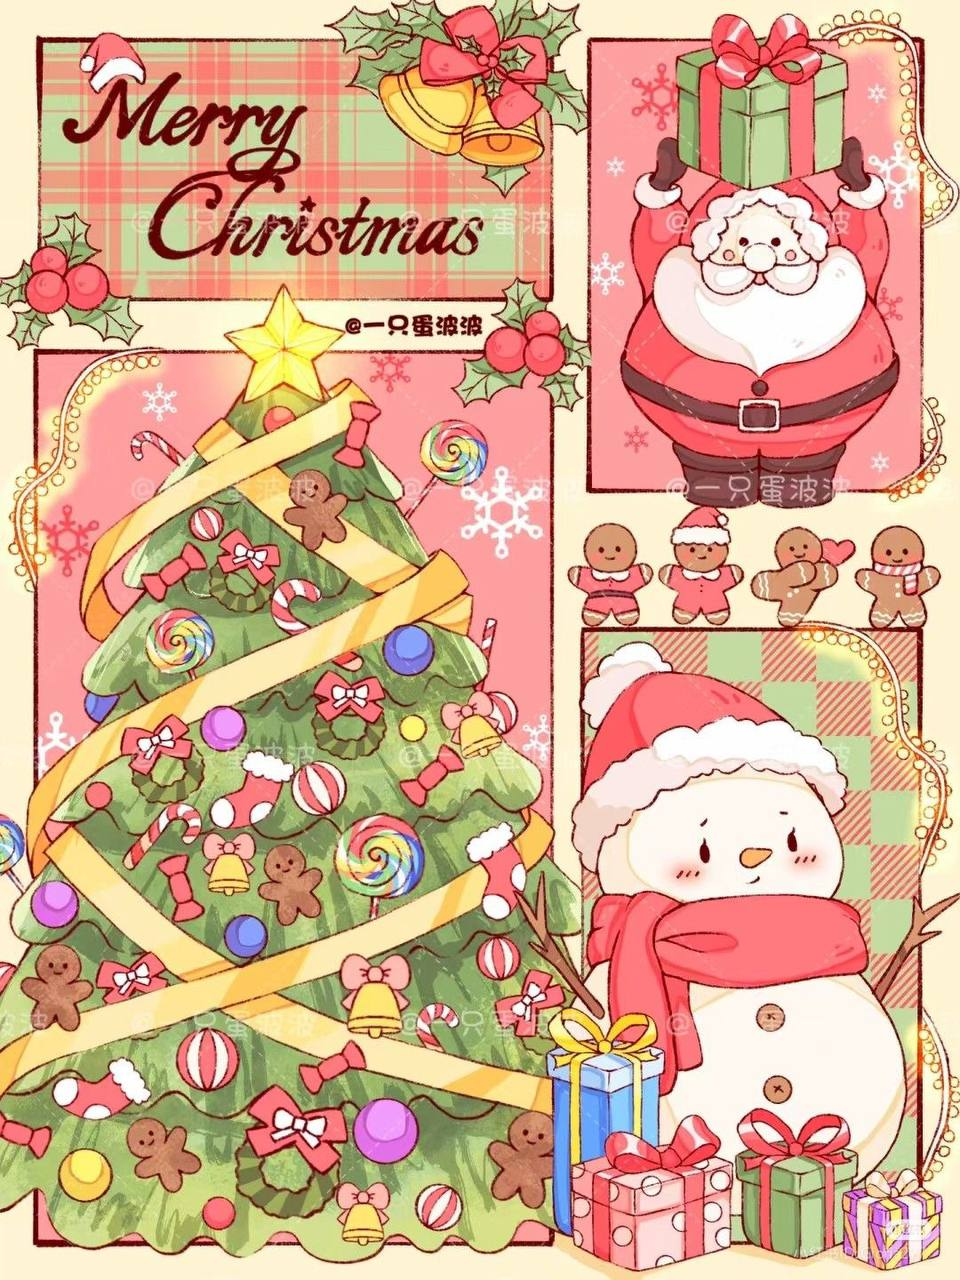

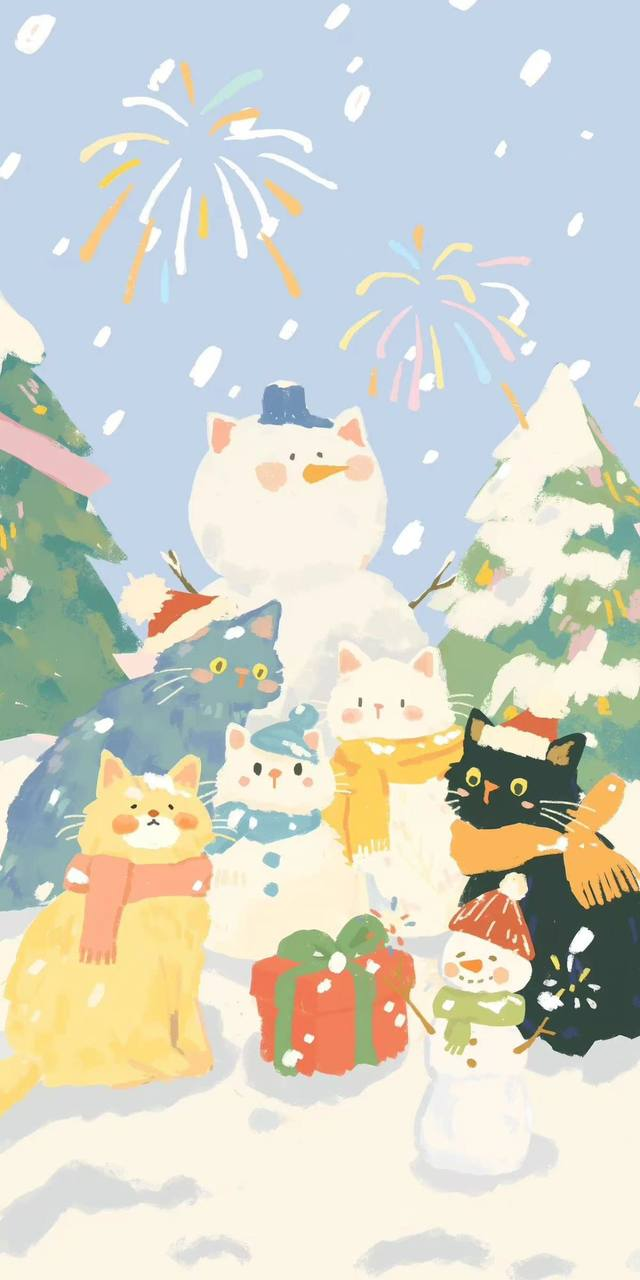

# Тест "Кто ты из новогодних игрушек?"

## Инструкция

1. На каждый вопрос выбери один вариант ответа A B C или D

2. В конце посчитай каких букв у тебя больше всего

### Вопрос 1
Как ты обычно относишься к подготовке к праздникам?

A. Планирую заранее продумываю детали люблю ощущение контроля

B. Важно собрать близких люди важнее сценария

C. Стараюсь сделать обстановку уютной и спокойной

D. Берусь за то что кажется интересным в моменте люблю спонтанность

### Вопрос 2
Какой рабочий или учебный день тебе кажется комфортным?

A. Когда есть понятный план задачи и сроки

B. Когда рядом знакомые люди можно обсудить дела и новости

C. Когда никто не дергает можно спокойно делать свое

D. Когда день отличается от предыдущих есть новые впечатления

### Вопрос 3
Какой формат зимнего вечера тебе ближе?

A. Навести порядок разобрать дела составить планы

B. Созвон или встреча с друзьями семейные истории

C. Дом еда плед фильм или книга

D. Гулять ходить в новые места пробовать что то непривычное

### Вопрос 4
Как ты реагируешь на изменения в планах?

A. Немного напрягаюсь но стараюсь быстро перестроиться

B. Спокойнее если есть поддержка со стороны близких

C. Предпочитаю чтобы изменений было поменьше

D. Часто радуюсь потому что так интереснее

### Вопрос 5
Что тебе важнее всего от нового года?

A. Чувство что можно структурировать жизнь обновить цели

B. Ощущение связи с людьми общие воспоминания традиции

C. Пауза и восстановление сил чувство безопасности

D. Новые идеи возможности впечатления

##Подсчет результатов
Посчитай сколько раз у тебя встретились буквы A B C и D

Буква у которой наибольшее количество ответов определяет твой тип игрушки

##Расшифровка

###Если больше всего A
Ты стеклянный шар классической формы

Ты про порядок и структуру любишь когда все продумано и на своих местах

Рядом с тобой людям легче собраться и организоваться

###Если больше всего B
Ты старая фигурка с историей та самая игрушка которую берегут годами

Ты про отношения и память помогаешь людям чувствовать связь друг с другом

Без тебя атмосфера кажется менее живой и теплой

###Если больше всего C
Ты мягкая светлая гирлянда

Ты создаешь ощущение уюта и спокойствия

С тобой пространство становится комфортным и безопасным

###Если больше всего D
Ты необычная самодельная игрушка

Ты приносишь в компанию новые идеи и неожиданные повороты

С тобой реже бывает скучно и чаще появляются интересные истории
